<a href="https://colab.research.google.com/github/alexv710/debias_cv_data/blob/main/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io
import os
import datetime

import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

import graphviz

# sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Data Preprocessing

In [2]:
# apply the min-max scaling in Pandas using the .min() and .max() methods
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

# read the mainsample.dta file for further processing 

data = pd.io.stata.read_stata("data_candidates_mainsample.dta")
data.to_csv('data_candidates_mainsample.csv')

# Import the mainsample via StataReader to use variable_labels (old version of the read_stata)

data_stata = pd.io.stata.StataReader("data_candidates_mainsample.dta")
data_labels = data_stata.variable_labels()

# Remove all columns in the dataset for which no labels exist
# Those are mostly columns needed for p-tests and some matrix calculations in
# Stata. The outputted labels are those that are kept in the data

data = data.drop(columns=['CVAxORIGINE_IM_12', 'CVAxZUS_CUCS', 'CVAxZetI', 'C', 'CVA0',\
                          'p_offre1', 'control_manquant', 'ZouI_pred', 'ZouI0', 'ALE_16'])

# Remove sampling weights (within and out of the experiment)

data = data.drop(columns='POIDS_SEL')

# Remove all the centered features

data = data.drop(columns=['FEMME_c', 'a30m_c', 'a3049_c', 'a50p_c', 'dip_aucun_c',\
                          'dip_bepcap_c', 'dip_bac_c', 'dip_bac2p_c', 'recherche_LD_c', 'recherche_TLD_c'])

# Remove all features that are not directly derivable from the CVs or that have missing data

data = data.drop(columns=['RECRUTE', 'REFUSAL', 'codage_cv', 'ORIGINE_IM_1', 'ORIGINE_IM_2',\
                          'ORIGINE_IM_12', 'ID_OFFRE', 'ID_CANDIDAT', 'travail_etranger', 'duree_expro_offre'])

# Remove additional features that seem to bring no value or are unclear in the methodology according to the original paper

data = data.drop(columns=['CV_hesit_', 'CV_hesit', 'CV_note_7p', 'ZetI', 'permis', 'CV_attrayant_'])

for key, value in data_labels.items():
    for col in data.columns:
        if key==col:
            # print(key, ':    ', value)
            if len(value)==0 or value.startswith('ID_OFFRE==') or value.startswith('Dummy for local job center'):
                data = data.drop(columns=col)

# clean up dataset nan values
# print(len(data))
# for item in data:
    # if data[item].isna().sum() > 0:
        # print(item, data[item].isna().sum())
        
# data.dropna(subset=['CV_note_7p', 'etudes_etranger', 'langue_anglais'],inplace=True)

data['CV_qualif_sup'] = data['CV_qualif_sup'].fillna(0)
data['CV_qualif_inf'] = data['CV_qualif_inf'].fillna(0)
data['PREN_MUSULMAN'] = data['PREN_MUSULMAN'].fillna(0)
data['ZUS_CUCS'] = data['ZUS_CUCS'].fillna(0)
data['recherche_TLD'] = data['recherche_TLD'].fillna(0)

data['etudes_etranger'] = data['etudes_etranger'].fillna(0)
data['langue_anglais'] = data['langue_anglais'].fillna(0)
data['langue_arabe'] = data['langue_arabe'].fillna(0)
data['langue_autres'] = data['langue_autres'].fillna(0)
data['CV_formation_'] = data['CV_formation_'].fillna(0)


# derived from CV_experience_3p

data['CV_experience_'] = data['CV_experience_'].fillna(0.5)


# fill with 1 since missing records are not in the other age groups

data['a26m'] = data['a26m'].fillna(1)

# Assign medium grade for all unknown records
data['CV_note_2'] = data['CV_note_2'].fillna(0)
data['CV_note_3'] = data['CV_note_3'].fillna(1)
data['CV_note_4'] = data['CV_note_4'].fillna(0)
data['CV_note_5'] = data['CV_note_5'].fillna(0)



# print(len(data))
for item in data:
    if data[item].isna().sum() > 0:
        print(item, data[item].isna().sum())

        
        
# Normalize remaining columns to values between 0 and 1
# call the min_max_scaling function

data = min_max_scaling(data)


CVA 203


In [3]:
# Create a dataframe for the anonymized and not anonymized data

X_ano = pd.DataFrame()
X_unano = pd.DataFrame()
X = pd.DataFrame()

for index, row in data.iterrows():
    if row['ENTRETIEN'] == 1:
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        
data.to_csv('fullData.csv')

for index, row in data.iterrows():
    if row['CVA'] == 1: 
        X_ano = X_ano.append(row)
    else:
        X_unano = X_unano.append(row)

# Assign the interviewed column to our target vector

y_ano = X_ano['ENTRETIEN']
y_unano = X_unano['ENTRETIEN']
y = data['ENTRETIEN']

# Drop the Interviewed/hired & anonymized columns (hired is much dependend on the number of jobs available
# and will currently not be considered as target label)
X_ano = X_ano.drop(columns=['CVA'])
X_unano = X_unano.drop(columns=['CVA'])
X = data.drop(columns=['CVA'])

<AxesSubplot:>

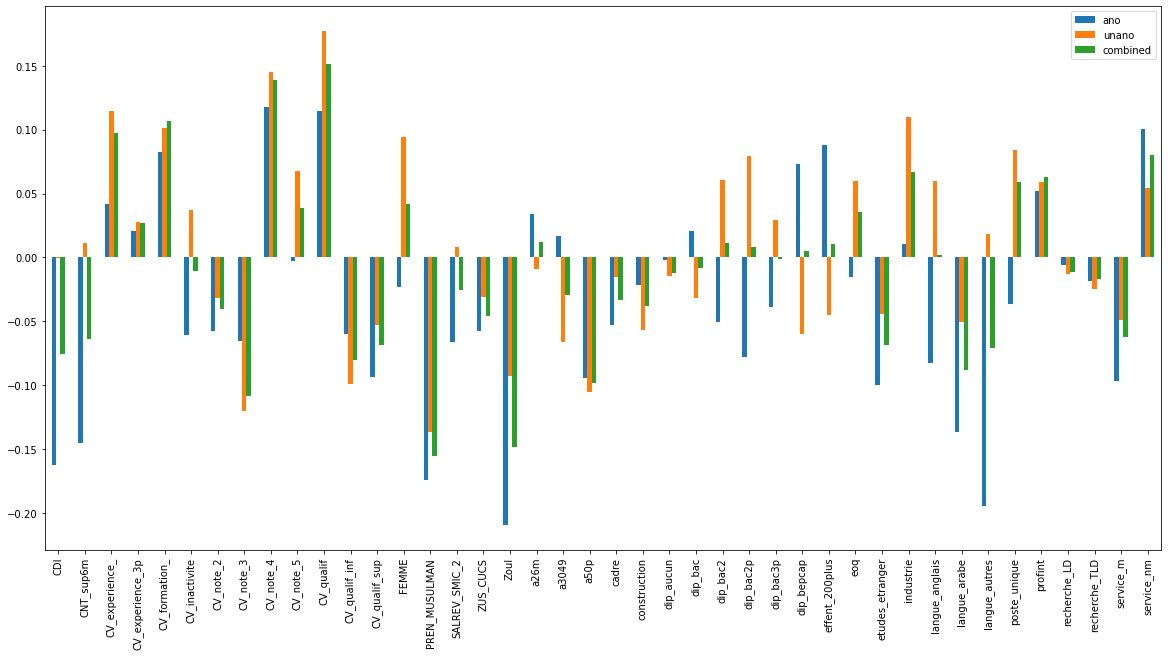

In [4]:
corrTable = pd.DataFrame()

corrTable['ano'] = X_ano.corr()['ENTRETIEN']
corrTable['unano'] = X_unano.corr()['ENTRETIEN']
corrTable['combined'] = data.corr()['ENTRETIEN']

corrTable.drop('ENTRETIEN', axis=0).plot.bar(figsize=(20,10))

In [5]:
X_ano = X_ano.drop(columns=['ENTRETIEN'])
X_unano = X_unano.drop(columns=['ENTRETIEN'])
X = X.drop(columns=['ENTRETIEN'])

### Data Preparation for models

In [6]:
# Train, Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

## Random Forest

In [7]:
# define the model
modelForest = RandomForestClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(modelForest, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

modelForest.fit(X_train, y_train)

y_pred = modelForest.predict(X_test)

errors = abs(y_pred - y_test)

print('Mean Absolute Error:', round(np.mean(errors), 3), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = sum(errors) / len(errors) * 100
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 3), '%.')

Accuracy: 0.976 (0.009)
Mean Absolute Error: 0.02 degrees.
Accuracy: 98.047 %.


In [8]:
# Extract single tree
estimator = modelForest.estimators_[5]
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = ['notInterviewed', 'Interviewed'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

import pydot

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')


# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## Testing Bias Random Forest

In [9]:
def compare_ratio(X, y, job_type):
    
    df = X
    df['y'] = y
    
    df = df[df[job_type] == 1]
    df_male = df[df['FEMME'] == 0]
    df_female = df[df['FEMME'] == 1]
    
    
    tot_female = df_female.shape[0]
    invited_female = df_female[df_female['y'] == 1].shape[0]
    female_ratio = invited_female/tot_female

    tot_male = df_male.shape[0]
    invited_male = df_male[df_male['y'] == 1].shape[0]
    male_ratio = invited_male/tot_male

    
    df_female_quali = df_female['CV_qualif']
    avg_female_quali = sum(df_female_quali)/tot_female
    
    df_male_quali = df_male['CV_qualif']
    avg_male_quali = sum(df_male_quali)/tot_male


    print('Average male qualification value: %f, are hired at a ratio of %f (total # applicants: %d)' %(avg_male_quali, male_ratio, tot_male))
    print('Average female qualification value: %f, are hired at a ratio of %f (total # applicants: %d)' %(avg_female_quali, female_ratio, tot_female))
    
def print_ratios(X, y):
    print('\n contruction:\n')

    compare_ratio(X, y, 'construction')

    print('\n service_nm:\n')

    compare_ratio(X, y, 'service_nm')

    print('\n service_m:\n')

    compare_ratio(X, y, 'service_m')

    print('\n industrie:\n')

    compare_ratio(X, y, 'industrie')


#### For the Training Data

In [12]:
print_ratios(X_train, modelForest.predict(X_train))


 contruction:

Average male qualification value: 0.699270, are hired at a ratio of 0.358974 (total # applicants: 39)
Average female qualification value: 0.396090, are hired at a ratio of 0.428571 (total # applicants: 14)

 service_nm:

Average male qualification value: 0.556740, are hired at a ratio of 0.531073 (total # applicants: 177)
Average female qualification value: 0.657997, are hired at a ratio of 0.571429 (total # applicants: 357)

 service_m:

Average male qualification value: 0.606186, are hired at a ratio of 0.466989 (total # applicants: 621)
Average female qualification value: 0.581716, are hired at a ratio of 0.464037 (total # applicants: 431)

 industrie:

Average male qualification value: 0.629933, are hired at a ratio of 0.583333 (total # applicants: 228)
Average female qualification value: 0.579443, are hired at a ratio of 0.569106 (total # applicants: 123)


<ipython-input-9-c9cff6be5cd3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = y
<ipython-input-9-c9cff6be5cd3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = y
<ipython-input-9-c9cff6be5cd3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['

#### For the Test Data

In [11]:
print_ratios(X_test, y_pred)


 contruction:

Average male qualification value: 0.545255, are hired at a ratio of 0.000000 (total # applicants: 2)
Average female qualification value: 0.500000, are hired at a ratio of 1.000000 (total # applicants: 2)

 service_nm:

Average male qualification value: 0.483620, are hired at a ratio of 0.440000 (total # applicants: 25)
Average female qualification value: 0.628622, are hired at a ratio of 0.744681 (total # applicants: 47)

 service_m:

Average male qualification value: 0.576230, are hired at a ratio of 0.435484 (total # applicants: 62)
Average female qualification value: 0.583500, are hired at a ratio of 0.395349 (total # applicants: 43)

 industrie:

Average male qualification value: 0.676723, are hired at a ratio of 0.518519 (total # applicants: 27)
Average female qualification value: 0.461538, are hired at a ratio of 0.538462 (total # applicants: 13)


<ipython-input-9-c9cff6be5cd3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = y
<ipython-input-9-c9cff6be5cd3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = y
<ipython-input-9-c9cff6be5cd3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['

## Support Vector Machine

In [ ]:


#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred) * 100, 2), '%.')

# Neural Network

The neural network "simpleNet" is built using Keras with one input layer with the activation function relu and one output layer using a sigmoid activation function for binary classification. In addition three hidden layers are addedm, all with relu activation function.

In [ ]:
# define the keras model

name="simpleNet"
model = keras.Sequential(
    [
        layers.Dense(128, input_dim=42, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.08)),
                
        layers.Dropout(0.5),
        layers.Dense(56, activation='relu'),
        layers.Dense(24, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(12, activation='relu'),
        
        layers.Dense(1, activation='sigmoid')  
    
    ],name=name
)
model.summary()

In [ ]:
from tensorflow.keras.optimizers import SGD
sgd = keras.optimizers.SGD(lr=.01, momentum=0.0, nesterov=True)


#Learning Rate Annealer
lrr = ReduceLROnPlateau(monitor='val_accuracy',
                       factor=.01,
                       patience=4,
                       min_lr=1e-8,
                       verbose=1)
#Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",\
                                      patience=8, verbose=0, mode="auto", baseline=None, restore_best_weights=True)


model.compile(optimizer="sgd", loss="mae", metrics=["mae", 'accuracy'])

model.fit(np.array(X_train), np.array(y_train), epochs=20, callbacks=[es, lrr], validation_split=0.2, shuffle=True, verbose=2)

_, _, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))